In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from sklearn.model_selection import train_test_split

In [2]:
# Reading the data
df = pd.read_pickle('./preprocessed_data.pkl')

In [3]:
# Character encoding into english values
label_map={"أ":0,"ا":0,"ب":1,"ج":2,"د":3,"ر":4,"ز":5,"س":6,"ص":7,"ط":8,"ع":9,"ف":10,"ق":11,"ل":12,"م":13,"ن":14,"ه":15,"و":16,"ي":17,"ى":17,
"١":18,"۱":18,"٢":19,"۲":19,"٣":20,"۳":20,"٤":21,"٥":22,"٦":23,"٧":24,"۷":24,"٨":25,"۸":25,"٩":26,"۹":26,"+":27,"ك":28,"ح":29}

In [4]:
# Used later for decoding the english values back into their Arabic equivalent
decoding=["أ","ب","ج","د","ر","ز","س","ص","ط","ع","ف","ق","ل","م","ن","ه","و","ي","١","٢","٣","٤","٥","٦","٧","٨","٩","+","ك","ح"]

In [5]:
# If any labels contains characters that do not have an encoding,
# drop that label with its image
for i,label in enumerate(df['label']):
    for char in label:
        if char not in label_map:
            df.drop(i,inplace=True)
            break
df.reset_index(inplace=True)

In [6]:
# Encode each character in each label
for i,label in enumerate(df['label']):
    temp = np.zeros((7))
    for j,char in enumerate(label):
        temp[j] = label_map[char] 
    df.at[i,'label'] = temp

In [7]:
temp_x = tf.convert_to_tensor(df['image'].tolist())
temp_y = tf.convert_to_tensor(df['label'].tolist())

temp_x = tf.reshape(temp_x,(-1, 64, 128, 1))

2022-12-24 07:24:00.707565: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 07:24:00.708591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 07:24:00.835335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 07:24:00.836303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-24 07:24:00.837122: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [8]:
# Initialize the image data generator
gen = IDG(rotation_range=15,shear_range=15,width_shift_range=0.05,
          height_shift_range=0.05,zoom_range=0.1)

In [9]:
# Generate images and seperate them from the labels
x = []
y = []
for i in range(7):
    aug = gen.flow(temp_x,
               temp_y,batch_size=1)
    x = x + [aug[i][0] for i in range(len(aug))]
    y = y + [aug[i][1] for i in range(len(aug))]

In [10]:
df['image']= df['image'].apply(lambda image: image.reshape(1,64,128,1))
df['label']= df['label'].apply(lambda label: label.reshape(1,7))

In [11]:
imageList = df['image'].tolist()
labelList = df['label'].tolist()

In [12]:
x = x + imageList
y = y + labelList

In [13]:
# Split data into train and test
train_x, test_x,train_y,test_y = train_test_split(x,y, test_size=0.4)

In [14]:
train_y = tf.convert_to_tensor(train_y)
test_y = tf.convert_to_tensor(test_y)

train_x = tf.convert_to_tensor(train_x)
test_x = tf.convert_to_tensor(test_x)

In [15]:
# Normalization
train_x = train_x / 255
test_x = test_x / 255

In [16]:
train_y = tf.reshape(train_y,(-1,7))
test_y = tf.reshape(test_y,(-1,7))

train_x = tf.reshape(train_x,(-1, 64, 128, 1))
test_x = tf.reshape(test_x,(-1, 64, 128, 1))

In [17]:
# Split the labels to allow the model to train on each character separately
train_y_split = [train_y[:,i] for i in range(7)]
test_y_split = [test_y[:,i] for i in range(7)]

In [18]:
def myModel():
    input = keras.Input(shape= (64,128,1))
    x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(input)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(64, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(128, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(512, (3, 3), activation='relu',)(x)
    x = keras.layers.MaxPooling2D((2, 2))(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(1024, activation='relu',)(x)
    x = keras.layers.Dropout(0.4)(x)
    out1 = keras.layers.Dense(30, activation='softmax',name='Char1')(x)
    out2 = keras.layers.Dense(30, activation='softmax',name='Char2')(x)
    out3 = keras.layers.Dense(30, activation='softmax',name='Char3')(x)
    out4 = keras.layers.Dense(30, activation='softmax',name='Char4')(x)
    out5 = keras.layers.Dense(30, activation='softmax',name='Char5')(x)
    out6 = keras.layers.Dense(30, activation='softmax',name='Char6')(x)
    out7 = keras.layers.Dense(30, activation='softmax',name='Char7')(x)
    model = keras.models.Model(inputs=input,outputs=[out1,out2,out3,out4,out5,out6,out7])
    return model

In [19]:
# Callback to calculate avg training and validation accuracy,
# and stop the training at 95%
class myCallBack(keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs={}):
        acc_list = [logs[f'Char{i}_accuracy'] for i in range(1,8)]
        avg_acc = np.mean(acc_list)
        print(f"\nAverage accuracy: {avg_acc}")

        val_acc_list = [logs[f'val_Char{i}_accuracy'] for i in range(1,8)]
        avg_val_acc = np.mean(val_acc_list)                     
        print(f"Averege validation accuracy: {avg_val_acc}\n")
        if(avg_val_acc > 0.95):
            print("We have done it! validation accuracy above 95%!! Stop the training...")
            self.model.stop_training = True
            
    def on_test_end(self,logs={}):
        acc_list = [logs[f'Char{i}_accuracy'] for i in range(1,8)]
        print(f"\nAverage accuracy: {np.mean(acc_list)}\n")
        
callbacks = myCallBack()

In [20]:
# Only needed for TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [21]:
# with tpu_strategy.scope():
model = myModel()
model.compile(optimizer="Adam",loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 128, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 62, 126, 64)  640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 31, 63, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 63, 64)   0           max_pooling2d[0][0]              
______________________________________________________________________________________________

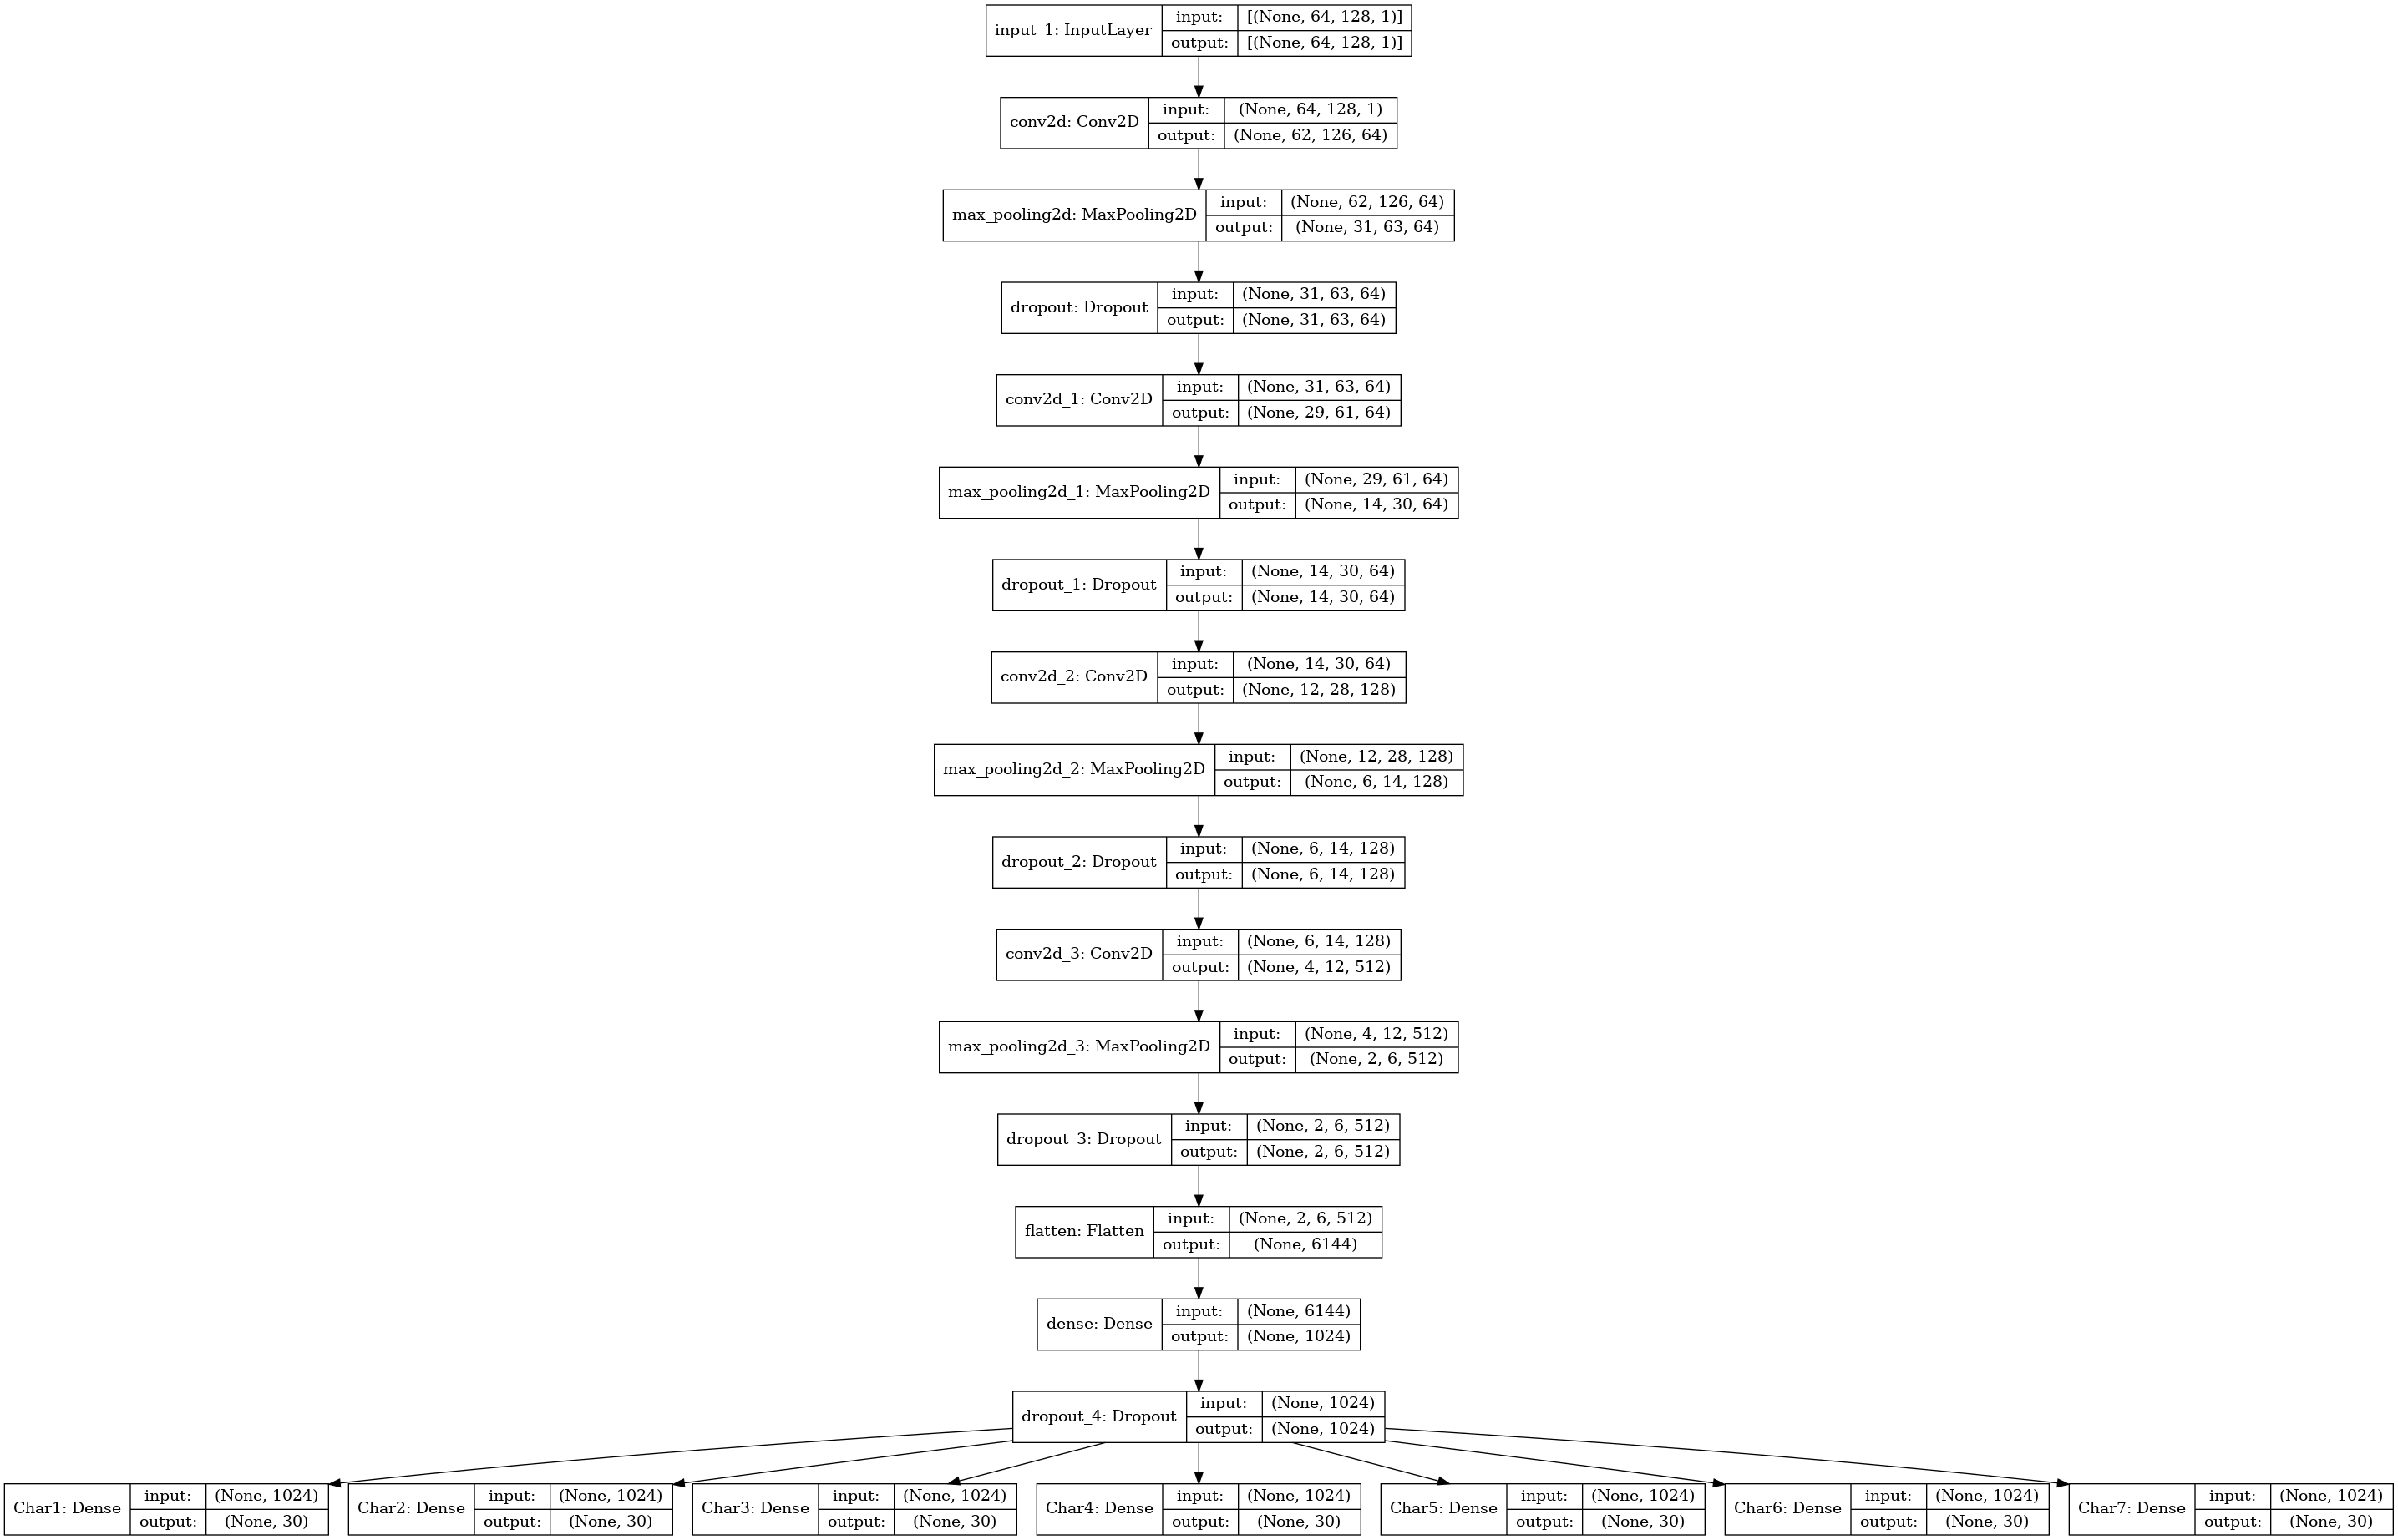

In [23]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [24]:
# Scaling the batch size with the number of tpu cores
# BATCH_SIZE = 8 * tpu_strategy.num_replicas_in_sync
BATCH_SIZE = 64

In [25]:
model.fit(train_x,[train_y_split[0],train_y_split[1],train_y_split[2],train_y_split[3],train_y_split[4],train_y_split[5],train_y_split[6]],validation_data=(test_x, test_y_split),epochs=70,batch_size=BATCH_SIZE,callbacks=[callbacks])

2022-12-24 07:28:02.581245: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/70


2022-12-24 07:28:05.646752: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


189/189 [==============================] - ETA: 0s - loss: 17.7802 - Char1_loss: 2.7909 - Char2_loss: 2.9238 - Char3_loss: 3.3112 - Char4_loss: 2.3190 - Char5_loss: 2.3519 - Char6_loss: 2.3521 - Char7_loss: 1.7313 - Char1_accuracy: 0.1421 - Char2_accuracy: 0.0752 - Char3_accuracy: 0.0505 - Char4_accuracy: 0.1231 - Char5_accuracy: 0.1147 - Char6_accuracy: 0.1204 - Char7_accuracy: 0.5581
Average accuracy: 0.18120067406977927

189/189 [==============================] - 20s 51ms/step - loss: 17.7802 - Char1_loss: 2.7909 - Char2_loss: 2.9238 - Char3_loss: 3.3112 - Char4_loss: 2.3190 - Char5_loss: 2.3519 - Char6_loss: 2.3521 - Char7_loss: 1.7313 - Char1_accuracy: 0.1421 - Char2_accuracy: 0.0752 - Char3_accuracy: 0.0505 - Char4_accuracy: 0.1231 - Char5_accuracy: 0.1147 - Char6_accuracy: 0.1204 - Char7_accuracy: 0.5581 - val_loss: 17.3636 - val_Char1_loss: 2.7378 - val_Char2_loss: 2.8761 - val_Char3_loss: 3.2787 - val_Char4_loss: 2.2519 - val_Char5_loss: 2.2849 - val_Char6_loss: 2.2851 - val_C

In [26]:
model.evaluate(test_x, test_y_split,callbacks=[callbacks])

252/252 [==============================] - 3s 11ms/step - loss: 1.1886 - Char1_loss: 0.1871 - Char2_loss: 0.1575 - Char3_loss: 0.1453 - Char4_loss: 0.1880 - Char5_loss: 0.1725 - Char6_loss: 0.2164 - Char7_loss: 0.1217 - Char1_accuracy: 0.9486 - Char2_accuracy: 0.9582 - Char3_accuracy: 0.9588 - Char4_accuracy: 0.9425 - Char5_accuracy: 0.9482 - Char6_accuracy: 0.9342 - Char7_accuracy: 0.9647

Average accuracy: 0.9507493206432888



[1.1885660886764526,
 0.18713629245758057,
 0.15752197802066803,
 0.14530079066753387,
 0.18800580501556396,
 0.1724502146244049,
 0.21642744541168213,
 0.12172349542379379,
 0.9486033320426941,
 0.9581626057624817,
 0.9587833881378174,
 0.9425202012062073,
 0.9482309222221375,
 0.9342023730278015,
 0.9647424221038818]

In [27]:
pred_y = np.array(model.predict(x=test_x))

In [28]:
img_index=777

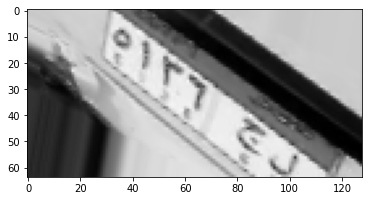

In [29]:
plt.imshow(test_x[img_index],cmap='gray')

In [30]:
pred_label = [decoding[np.argmax(pred_y[i][img_index])] for i in range(7)]
print(pred_label)

['ل', 'ج', '٦', '٣', '١', '٥', '+']


In [31]:
import cv2

In [32]:
# Takes image path as input and prints the image with the predicted label
def predictLabel(path):
    image = cv2.imread(path)
    temp = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    temp = cv2.resize(temp,(128,64))
    temp = tf.convert_to_tensor(temp)
    temp = tf.reshape(temp,(1,64,128,1))
    temp = temp/255
    pred = model.predict(temp)
    label = [decoding[np.argmax(pred[i])] for i in range(7)]
    label = " ".join([char for char in label if char!='+'])
    plt.imshow(image)
    print(label)
    

ل ج ٦ ٣ ٨ ٤


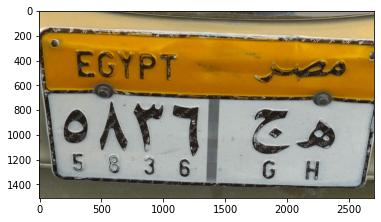

In [33]:
image_path = "./test_images/IMG_20221220_163222_1.jpg"
predictLabel(image_path)

In [34]:
model.save("predict_car_plate_modelv4")

2022-12-24 07:33:40.684721: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
